In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12, 14, 16)

In [4]:
# load data
PATH = "data/bulldozers/"

%time df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

Wall time: 187 ms


In [5]:
def split_vals(a, n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((389125, 66), (12000, 66), (389125,), (12000,))

In [6]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [8]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [9]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2061902693433735, 0.24940212401068843, 0.9111471918610701, 0.8889168287798849, 0.8941076794175533]


In [11]:
# To know the confidence of estimate, use std deviation instead of just mean
# This tells us the relative confidence of predictions.
# bagging
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.11 s


(9.290307484057399, 0.3090255955213585)

In [12]:
# using parallel_trees : calls function on every tree in parallel
# for faster computation
def parallel_trees(m, fn, n_jobs=8):
    return list(ThreadPoolExecutor(n_jobs).map(fn, m.estimators_))

In [13]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.03 s


(9.290307484057399, 0.3090255955213585)

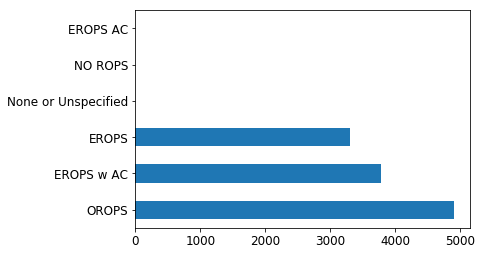

In [14]:
# plotting
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [15]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839160,0.274780
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579080,0.263277
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.676534,0.225846


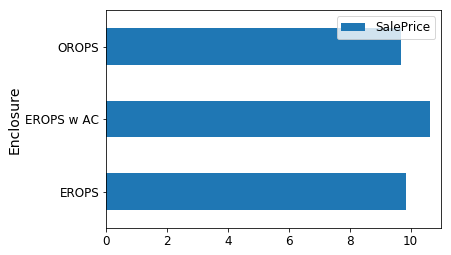

In [16]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

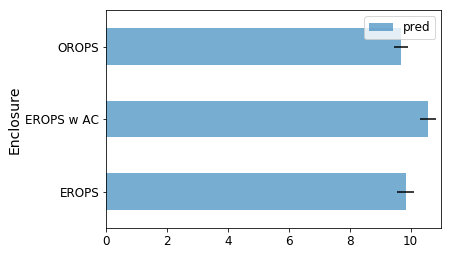

In [17]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

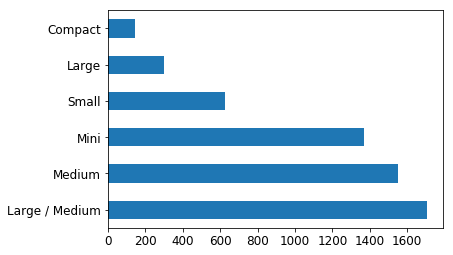

In [18]:
raw_valid.ProductSize.value_counts().plot.barh();

In [19]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.825361,0.328664
Large,10.470589,10.390994,0.351875
Large / Medium,10.691871,10.649564,0.293037
Medium,10.681511,10.614742,0.287791
Mini,9.535147,9.567520,0.242481
Small,10.324448,10.318949,0.324571


In [20]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.033863
Compact           0.033451
Small             0.031454
Large / Medium    0.027516
Medium            0.027112
Mini              0.025344
dtype: float64

In [21]:
# Feature Importance
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175011
37,Coupler_System,0.111663
13,ProductSize,0.103918
14,fiProductClassDesc,0.080007
2,ModelID,0.057432
39,Hydraulics_Flow,0.052343
63,saleElapsed,0.050233
10,fiSecondaryDesc,0.038282
19,Enclosure,0.035608
8,fiModelDesc,0.032499


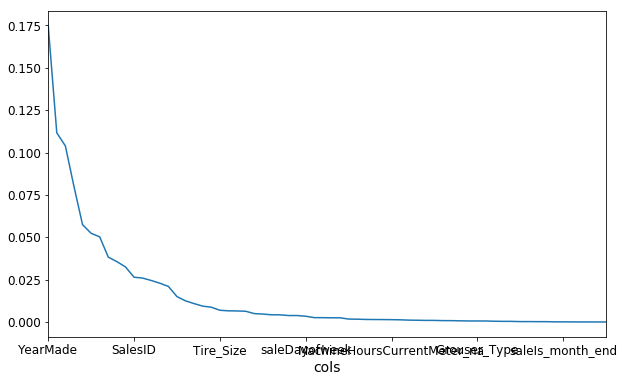

In [22]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [23]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

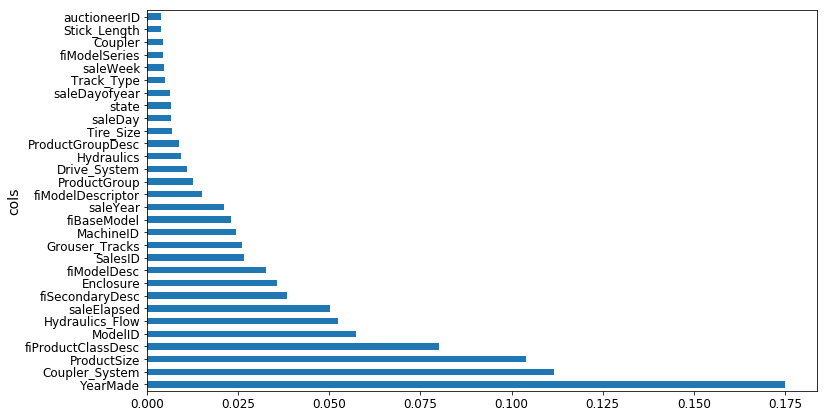

In [24]:
plot_fi(fi[:30]);

In [25]:
# keep the useful data
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [26]:
df_keep = df_trn[to_keep].copy()

X_train, X_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20699078057200906, 0.24686001128958762, 0.9104559299159832, 0.8911697910450055, 0.8940563280305477]


In [28]:
# slight change on rmse. So there is slightly better opportunity 
# to create a slightly better tree with slightly less data.
# But it is going to make it a bit faster and it is going to let us focus on what matters

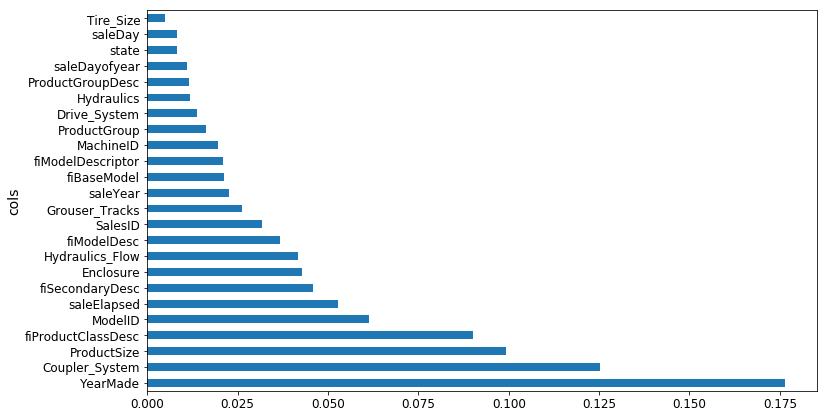

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [30]:
# collinearity removed

In [31]:
# one hot encoding
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.206826063219535, 0.2527775133675031, 0.9105983864400163, 0.8858896996353246, 0.8929346101178744]


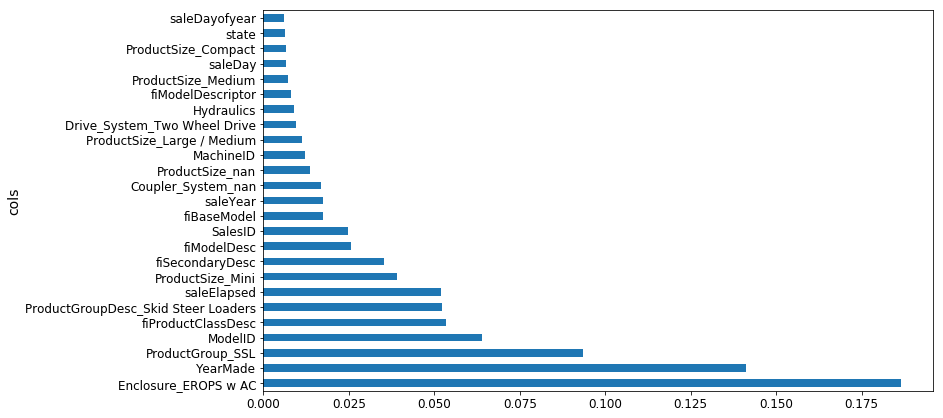

In [32]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [33]:
# removing redundant features
from scipy.cluster import hierarchy as hc

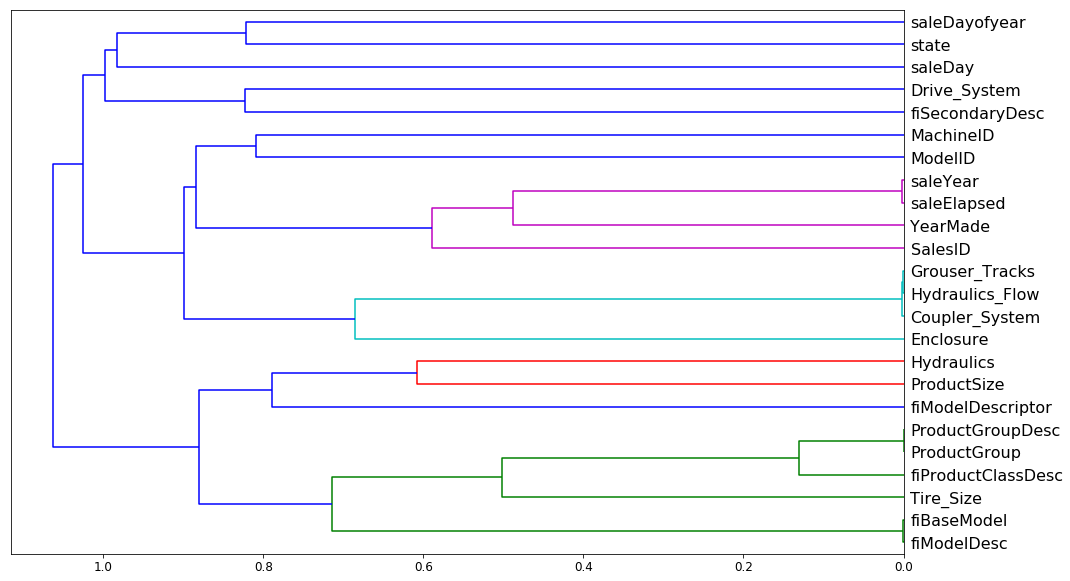

In [34]:
# dendograms
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [35]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, 
                              n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [36]:
get_oob(df_keep)

0.8906628348856412

In [37]:
# removing one variable at a time
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.888632819293909
saleElapsed 0.8869053311618353
fiModelDesc 0.8888053285839357
fiBaseModel 0.8897470041462385
Grouser_Tracks 0.8905887381204787
Coupler_System 0.8903520059691981


In [38]:
# dropping similar features
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8883387685956515

In [39]:
to_drop1 = ['saleElapsed', 'fiModelDesc', 'Coupler_System']
get_oob(df_keep.drop(to_drop1, axis=1))

0.8855156901012465

In [40]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [41]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [42]:
keep_cols = np.load('tmp/keep_cols.npy', allow_pickle=True)
df_keep = df_trn[keep_cols]

In [43]:
reset_rf_samples()

In [44]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12611438375781267, 0.22752687832062435, 0.9667597661618169, 0.9075486216025828, 0.9081027113156376]


In [45]:
# partial dependence
from pdpbox import pdp
from plotnine import *

In [46]:
set_rf_samples(50000)

In [47]:
# one hot encoding
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

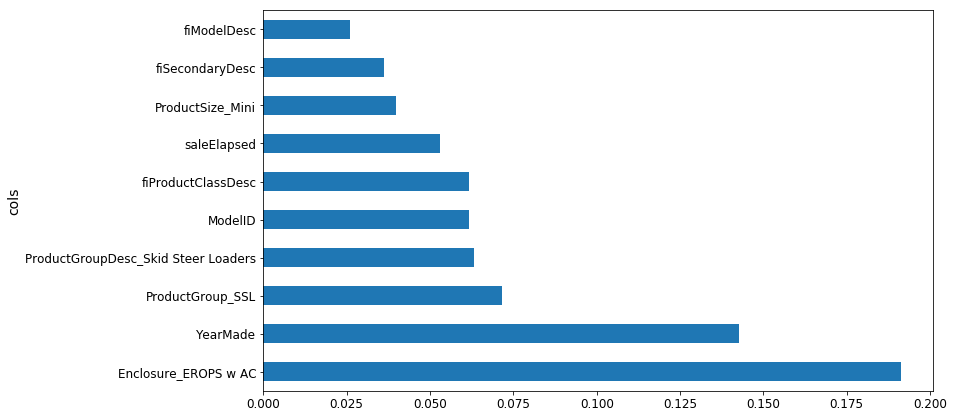

In [48]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

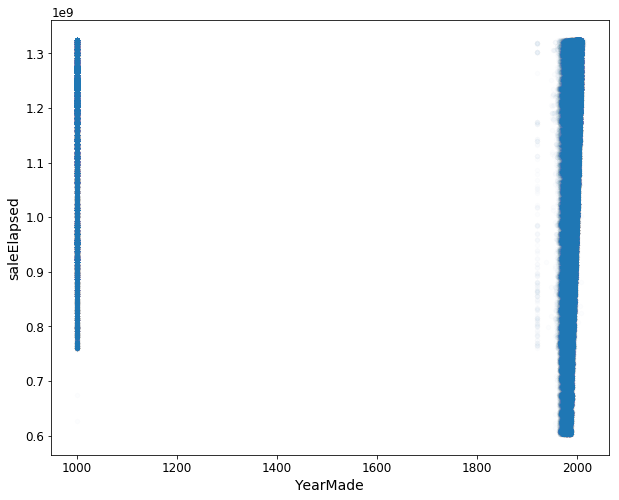

In [49]:
# YearMade vs saleElapsed
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [50]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

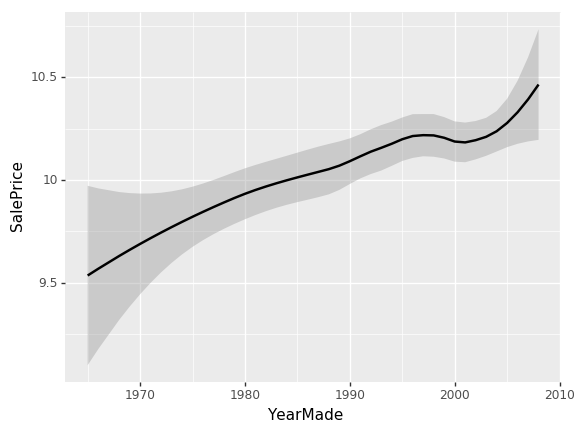

<ggplot: (-9223371879272489349)>

In [51]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [52]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [53]:
# pdp
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

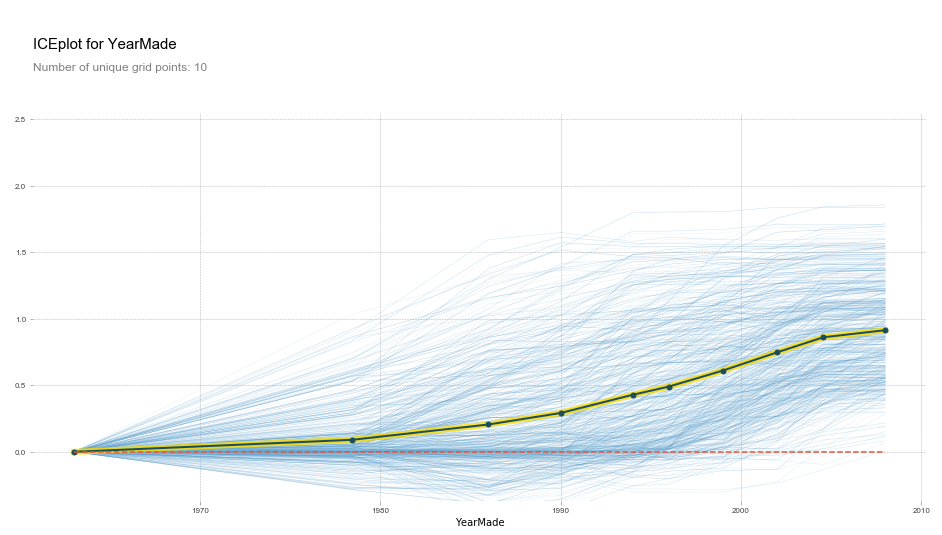

In [54]:
plot_pdp('YearMade')

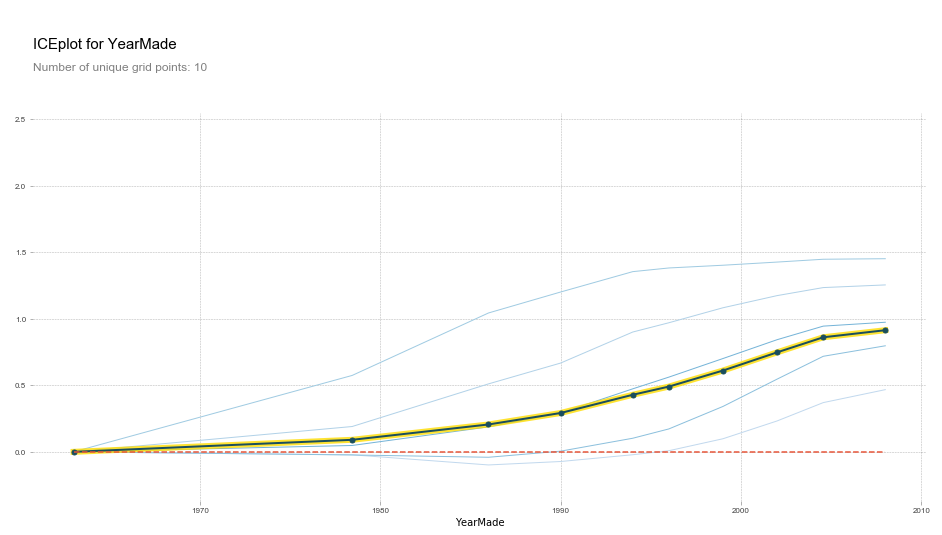

In [55]:
plot_pdp('YearMade', clusters=5)

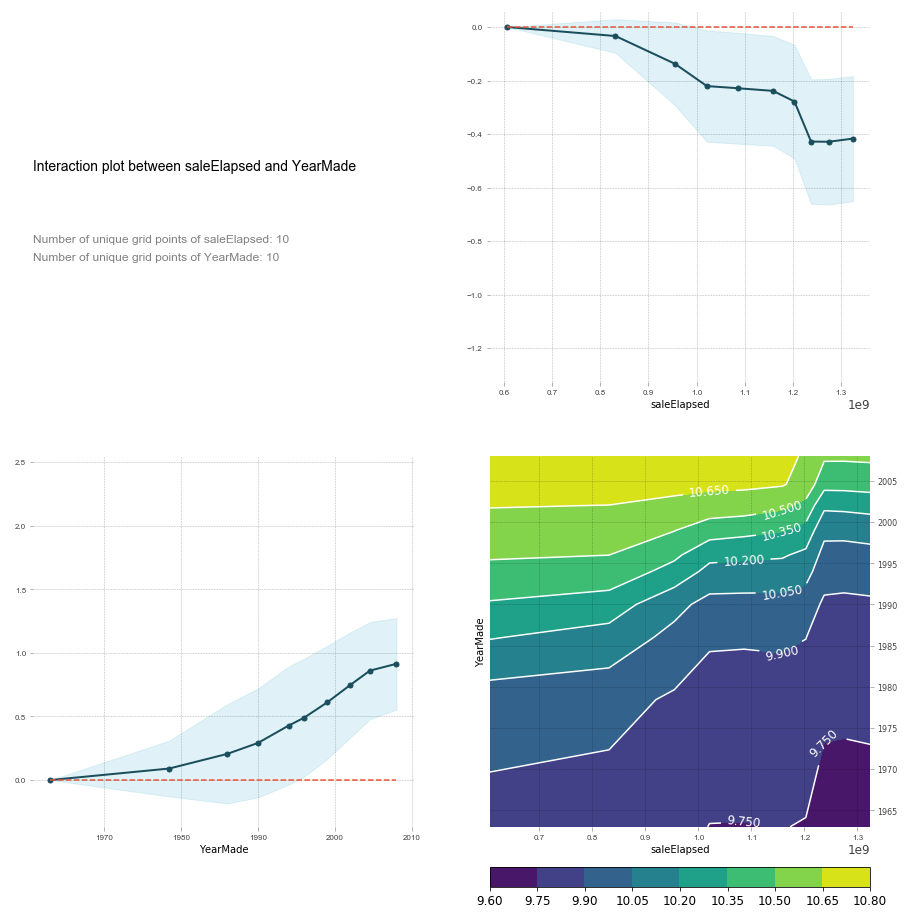

In [56]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

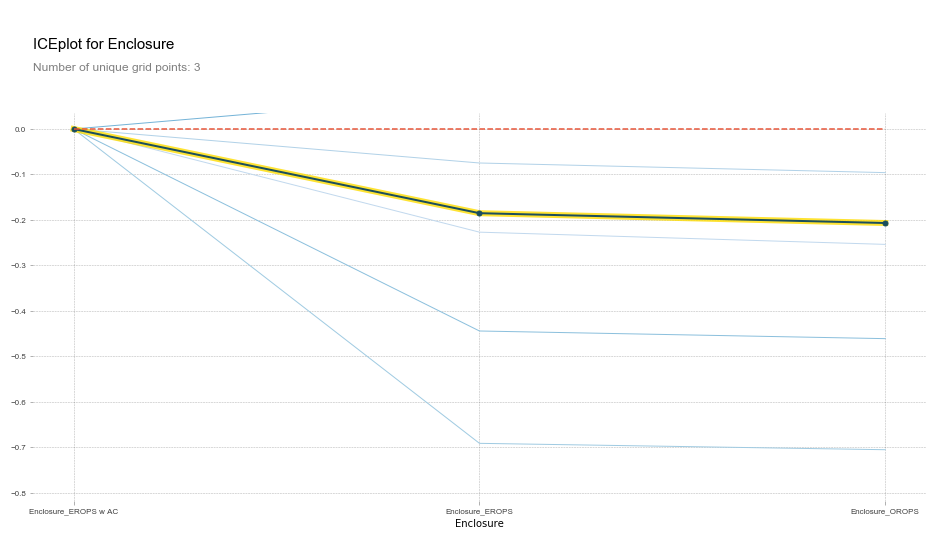

In [57]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [58]:
# adding new feature
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

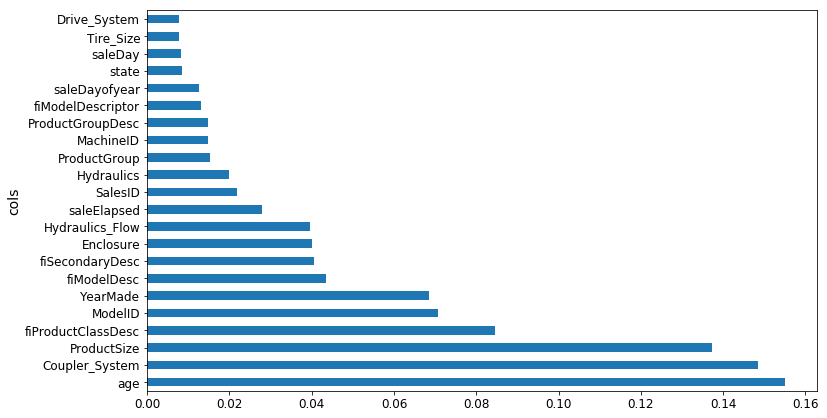

In [59]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [60]:
# Tree interpreter
from treeinterpreter import treeinterpreter as ti

In [61]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [62]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665,          0, 1284595200,          0,
                 1,       3232,    4364751,    2300944,          0,          4,          0,         12,
                 4,          0,         16,         35,        259,         11]], dtype=int64)

In [63]:
prediction, bias, contributions = ti.predict(m, row)

In [64]:
prediction[0], bias[0]

(array([9.32805]), 10.105662972815258)

In [65]:
idxs = np.argsort(contributions[0])

In [66]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5092571331720059),
 ('age', 11, -0.10989632783451161),
 ('fiModelDesc', 'KX1212', -0.10571208353736594),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.08106989986443498),
 ('fiSecondaryDesc', nan, -0.06083574074461007),
 ('saleElapsed', 1284595200, -0.04012320380172376),
 ('Enclosure', 'EROPS', -0.022775598482475255),
 ('fiModelDescriptor', nan, -0.01951615118437764),
 ('saleDayofyear', 259, -0.016969274084614617),
 ('SalesID', 4364751, -0.014144170304572734),
 ('MachineID', 2300944, -0.0013411618797968927),
 ('ProductGroupDesc', 'Track Excavators', -0.0010515460699618284),
 ('Tire_Size', nan, 0.0),
 ('saleDay', 16, 0.0014464216672002372),
 ('Drive_System', nan, 0.0030977307690977173),
 ('state', 'Ohio', 0.004088822582262797),
 ('Hydraulics', 'Standard', 0.006258580775000233),
 ('ProductGroup', 'TEX', 0.012494230861654776),
 ('Hydraulics_Flow', nan, 0.018978315520321188),
 ('ModelID', 665, 0.031281045056980525),
 ('Cou

In [67]:
contributions[0].sum()

-0.7776166960776084

In [68]:
# extrapolation
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [69]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                           n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999975070115301

In [70]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.785620
6,saleElapsed,0.134766
11,MachineID,0.069217
4,ModelID,0.002646
20,saleDayofyear,0.002324
9,fiModelDesc,0.002145
0,YearMade,0.001337
5,Hydraulics_Flow,0.000498
7,fiSecondaryDesc,0.000371
1,Coupler_System,0.000258


In [71]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [72]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [73]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [74]:
x.drop(feats, axis=1, inplace=True)

In [75]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                           n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9787098784668121

In [76]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.228879
0,YearMade,0.189631
17,saleDayofyear,0.158858
4,ModelID,0.077733
8,fiModelDesc,0.063337
15,saleDay,0.060749
16,state,0.055201
3,fiProductClassDesc,0.032066
6,fiSecondaryDesc,0.024476
7,Enclosure,0.021827


In [77]:
set_rf_samples(50000)

In [78]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [79]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20794096886325442, 0.24899881991829492, 0.9096319413833583, 0.8892757998577195, 0.8930879973673683]


In [80]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                              n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20984977063503574, 0.24698966883530998, 0.9079652527830652, 0.8910554398921466, 0.8917228647651215]
saleElapsed
[0.21444764779559655, 0.2549099858396833, 0.9038880474866419, 0.8839562721974473, 0.8868301808069515]
MachineID
[0.2069068036440199, 0.24657917937308899, 0.91052857190064, 0.891417264189938, 0.8949295308616392]
age
[0.20939366451906588, 0.24821050277425238, 0.9083648909816465, 0.8899757840115616, 0.8917981477797114]
YearMade
[0.2090060413428904, 0.251544501109776, 0.9087038412112736, 0.8870002117336783, 0.8922063054073576]
saleDayofyear
[0.20907735749948483, 0.2434283264826819, 0.9086415272042317, 0.8941745312560627, 0.8926255424108813]


In [81]:
reset_rf_samples()

In [82]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13866160888666867, 0.21918954261013593, 0.9598165430439664, 0.9141999314579099, 0.9090273314150304]


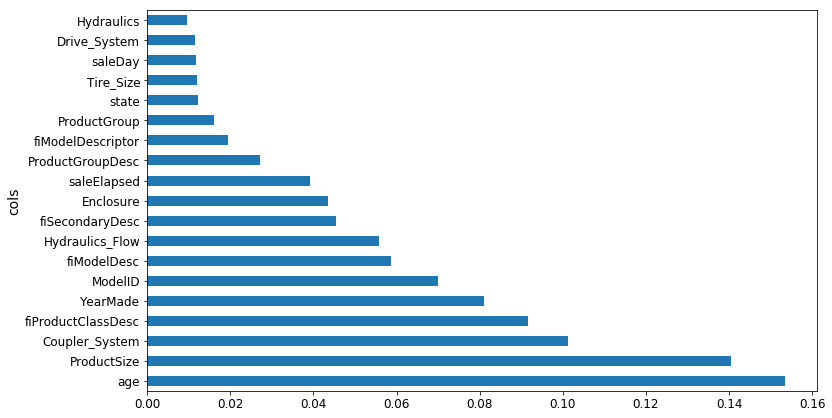

In [83]:
plot_fi(rf_feat_importance(m, X_train));

In [84]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [85]:
# Final Model
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 2min 11s
[0.08021726281358726, 0.21121986778587495, 0.9865516035372471, 0.9203258375355658, 0.9145155722990808]
